# 2. Data Cleaning

This notebook contains code which reads in area/route information gathered during the scraping process. 


In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import pickle
import warnings

import requests
from bs4 import BeautifulSoup
import functools
import operator
import os
from MPAreaTree import MPAreaTree
pd.set_option('display.max_colwidth', 4000)
warnings.filterwarnings('ignore')

# Data Cleaning and Preprocessing

In [31]:
def clean_routes(routes, drop_unrated = True):
    cleaned_routes = routes.drop_duplicates()
    
    if drop_unrated:
        cleaned_routes = cleaned_routes[~cleaned_routes.star_ratings.isnull()]
        cleaned_routes = cleaned_routes[cleaned_routes['star_ratings'] != '{}']
        
    cleaned_routes['description'] = cleaned_routes['description'].fillna('')
    cleaned_routes['id'] = cleaned_routes['id'].astype(int)
    cleaned_routes = cleaned_routes.rename(columns = {'id' : 'route_id', 'name' : 'route_name'})
    cleaned_routes['area_id'] = cleaned_routes['area_id'].astype(int)
    cleaned_routes['pitches'] = cleaned_routes['pitches'].astype(int)
    cleaned_routes['votes'] = cleaned_routes['votes'].astype(int)
    cleaned_routes['route_name'] = cleaned_routes['route_name'].fillna('Unnamed')
    cleaned_routes['height'] = cleaned_routes['height'].map(lambda x: 'Unspecified' if x == 0 else x)
    # dictionary of user ratings is saved as a string, convert to a python dict
    cleaned_routes['star_ratings'] = cleaned_routes['star_ratings'].map(lambda x: ast.literal_eval(x))
    
    
    # add ordinal grading for sorting
    boulder_grades = pd.read_csv('./data/boulder_grades.csv')
    climb_grades = pd.read_csv('./data/climb_grades.csv')
    
    
    grade_dict = {v:k for k,v in boulder_grades.to_dict()['grade'].items()}
    grade_dict.update({v:k for k,v in climb_grades.to_dict()['grade'].items()})
    
    # remove ungraded routes for now
    cleaned_routes = cleaned_routes[~cleaned_routes['grade'].isin(['5.?', 'V?', ''])]
    cleaned_routes = cleaned_routes[cleaned_routes['grade'].isin(grade_dict.keys())]
    
    cleaned_routes = cleaned_routes[cleaned_routes['pitches'] != 80]
    cleaned_routes['grade_numeric'] = cleaned_routes['grade'].map(grade_dict).astype(int)
    return cleaned_routes

def clean_area(areas):
    cleaned_areas = areas.drop_duplicates()
    
    cleaned_areas['parent_id'] = cleaned_areas['parent_id'].fillna(0)
    cleaned_areas['parent_id'] = cleaned_areas['parent_id'].astype(int)
    cleaned_areas = cleaned_areas.rename(columns = {'id' : 'area_id', 'name' : 'area_name'})
    return cleaned_areas

In [32]:
def get_ratings(routes):
    ratings = []
    for i,row in routes.iterrows():
        for user, stars in row['star_ratings'].items():
            ratings.append({'user_id': user, 'route_id' : row['route_id'], 'user_rating' : stars})

    ratings = pd.DataFrame(ratings)
    
    return pd.merge(ratings, routes, left_on = 'route_id', right_on='route_id').drop(columns = 'star_ratings')

In [34]:
def load_state_routes_areas(states):
    routes = []
    areas = []
    for state in states:
        if os.path.exists(f'./data/{state}_routes.csv') and os.path.exists(f'./data/{state}_areas.csv'):
            print(f'Found route/area data for {state}.')
            r = clean_routes(pd.read_csv(f'./data/{state}_routes.csv',quoting=2, error_bad_lines=False))        
            a = clean_area(pd.read_csv(f'./data/{state}_areas.csv'))

            r['state'] = state
            a['state'] = state
            r = r.merge(a[['area_id', 'area_name']], left_on = 'area_id', right_on = 'area_id')
            routes.append(r)
            areas.append(a)            
    
    routes = pd.concat(routes).reset_index(drop = True)
    areas = pd.concat(areas).reset_index(drop = True)
    print(f'Loaded route/area data for {areas["state"].unique().shape[0]} states.')
    print(f"Found {routes['route_id'].unique().shape[0]} unique routes in {areas['area_id'].unique().shape[0]} unique areas.")
    return routes, areas

In [35]:
state_names = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", 
               "Delaware", "Florida", "Georgia",  "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas",
               "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", 
               "Mississippi", "Montana", "North Carolina",  "North Dakota", "Nebraska", "New Hampshire", 
               "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", 
               "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", 
               "Tennessee", "Texas", "Utah", "Virginia",  "Vermont", 
               "Washington", "Wisconsin", "West Virginia", "Wyoming"]
routes, areas = load_state_routes_areas(state_names)

Found route/area data for Alaska.
Found route/area data for Alabama.
Found route/area data for Arkansas.
Found route/area data for Arizona.
Found route/area data for California.
Found route/area data for Colorado.
Found route/area data for Connecticut.
Found route/area data for Delaware.
Found route/area data for Florida.
Found route/area data for Georgia.
Found route/area data for Hawaii.
Found route/area data for Iowa.
Found route/area data for Idaho.
Found route/area data for Illinois.
Found route/area data for Indiana.
Found route/area data for Kansas.
Found route/area data for Kentucky.
Found route/area data for Louisiana.
Found route/area data for Massachusetts.
Found route/area data for Maryland.
Found route/area data for Maine.
Found route/area data for Michigan.
Found route/area data for Minnesota.
Found route/area data for Missouri.
Found route/area data for Mississippi.
Found route/area data for Montana.
Found route/area data for North Carolina.
Found route/area data for Nor

In [36]:
area_tree = MPAreaTree(areas)
ratings = get_ratings(routes)

In [37]:
ratings.shape

(2223674, 15)

In [38]:
routes.to_csv('./data/routes.csv', index = False)
areas.to_csv('./data/areas.csv', index = False)
ratings.to_csv('./data/ratings.csv', index = False)

In [39]:
pickle.dump(area_tree, open('./pickle/area_tree.pkl', 'wb'))

In [40]:
routes['score'].mean()

2.383954171987567

In [41]:
routes['votes'].mean()

13.17930029154519

In [42]:
ratings['user_rating'].mean()

2.7212617496989218

In [43]:
routes.head()

,route_name,route_id,type,area_id,grade,height,pitches,score,votes,description,star_ratings,grade_numeric,state,area_name
0,Kachemak Crack,107324402,Trad,107320915,5.7,70,1,1.0,1,Cruxy start with poor placement for the first 10-15 feet coupled with a nasty area to land if you do happen to peel off. Then cruise up the veiny cracks to the chains.,{106771928: 1},10,Alaska,Homer
1,Salty Dawg,107324612,Trad,107320915,5.10a,115,1,2.0,1,"Start up the steppy corner staying in the dihedral as much as possible. 6 bolts, bring cams for longer run out sections. Crux about midway at an overhanging slab. Work left at the top of climb.",{106771928: 2},18,Alaska,Homer
2,Nameless for now....,116613597,Boulder,116613587,V2-3,13,1,3.0,1,"Looking at the crack, start with one hand in the triangle hold in the crack, and the other on a jug about three feet from the ground. Work your way up the arete with holds on both sides. The top is still mossy, so it can’t be topped. There is potential to top it, it just needs to be cleaned.",{200331485: 3},12,Alaska,Barbara Falls
3,Fluffy Muff,110446548,Boulder,106906353,V10,15,1,2.0,1,"Line up the middle of the main face, very shoulder intensive. Stand start with right hand on a small sharp incut crimp just above head height and left hand on one of several holds to the left at head height. Move left hand up to a gaston, and reach right to the big hold in the middle of the face, match finish straight over the bulge on the same finish as Powder Puff. The sit start is V11 and starts with left hand on a good pinch, right hand on a crappy side-pull.",{107322604: 2},42,Alaska,The House of Bouldering
4,Groovy Movie,106906373,Boulder,106906353,V9-10,11,1,2.0,2,"Start low on small crimps either making a large move left to the top, or using small intermediate to hit the same ending point. Short and Tall beta is possible.","{106325793: 2, 107322604: 2}",40,Alaska,The House of Bouldering


In [44]:
ratings.groupby('user_id').count().mean()

route_id         36.840803
user_rating      36.840803
route_name       36.840803
type             36.840803
area_id          36.840803
grade            36.840803
height           36.840803
pitches          36.840803
score            36.840803
votes            36.840803
description      36.840803
grade_numeric    36.840803
state            36.840803
area_name        36.840803
dtype: float64

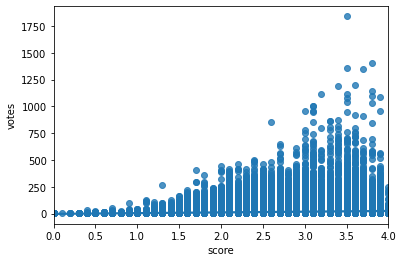

In [45]:
sns.regplot(data = routes, x = 'score', y = 'votes')

Text(0, 0.5, 'P')

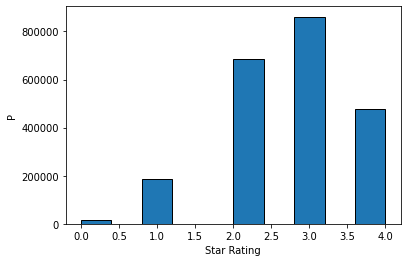

In [46]:
#myarray = ratings['user_rating']
#weights = np.ones_like(myarray)/float(len(myarray))
#plt.hist(myarray, weights=weights, edgecolor = 'black')
ratings['user_rating'].hist(bins = 10, grid=False,edgecolor = 'black', density = False)
plt.xlabel('Star Rating')
plt.ylabel('P')

In [47]:
ratings.groupby('user_id').count()

,route_id,user_rating,route_name,type,area_id,grade,height,pitches,score,votes,description,grade_numeric,state,area_name
user_id,,,,,,,,,,,,,,
10101,88,88,88,88,88,88,88,88,88,88,88,88,88,88
10102,176,176,176,176,176,176,176,176,176,176,176,176,176,176
10103,4,4,4,4,4,4,4,4,4,4,4,4,4,4
10104,9,9,9,9,9,9,9,9,9,9,9,9,9,9
10105,8,8,8,8,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200992330,1,1,1,1,1,1,1,1,1,1,1,1,1,1
200992512,1,1,1,1,1,1,1,1,1,1,1,1,1,1
200992608,1,1,1,1,1,1,1,1,1,1,1,1,1,1


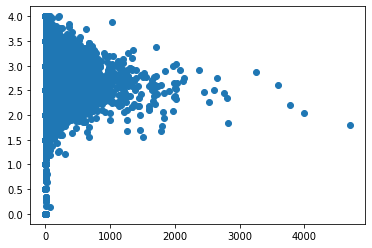

In [48]:
plt.scatter( x = ratings.groupby('user_id').count()['user_rating'], y = ratings.groupby('user_id')['user_rating'].mean())

In [49]:
ratings['user_rating'].value_counts(normalize=True)

3    0.387398
2    0.307793
4    0.215014
1    0.083423
0    0.006371
Name: user_rating, dtype: float64

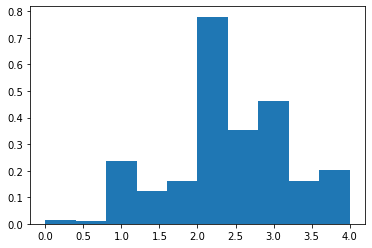

In [50]:
routes['score'].hist(bins = 10, grid = False, density = 1)

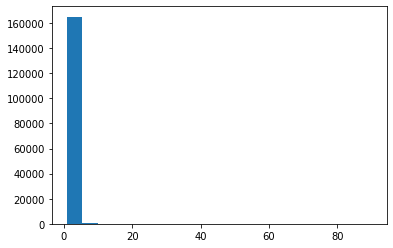

In [51]:
routes['pitches'].hist(bins = 20, grid = False)

In [52]:
routes['pitches'].value_counts().sort_values('index', ascending = False)

1     155716
2       5398
3       2238
4       1116
5        616
6        346
7        181
8        133
10        73
9         66
12        35
11        24
13        15
14        14
15         7
18         7
17         6
19         4
20         3
16         2
21         2
23         2
25         2
30         2
29         1
44         1
22         1
90         1
Name: pitches, dtype: int64

In [53]:
routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166012 entries, 0 to 166011
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   route_name     166012 non-null  object 
 1   route_id       166012 non-null  int64  
 2   type           166012 non-null  object 
 3   area_id        166012 non-null  int64  
 4   grade          166012 non-null  object 
 5   height         166012 non-null  object 
 6   pitches        166012 non-null  int64  
 7   score          166012 non-null  float64
 8   votes          166012 non-null  int64  
 9   description    166012 non-null  object 
 10  star_ratings   166012 non-null  object 
 11  grade_numeric  166012 non-null  int64  
 12  state          166012 non-null  object 
 13  area_name      166012 non-null  object 
dtypes: float64(1), int64(5), object(8)
memory usage: 17.7+ MB


In [54]:
areas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43668 entries, 0 to 43667
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   area_name  43668 non-null  object 
 1   area_id    43668 non-null  int64  
 2   parent_id  43668 non-null  int64  
 3   elevation  35451 non-null  object 
 4   latitude   43668 non-null  float64
 5   longitude  43668 non-null  float64
 6   state      43668 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 2.3+ MB


In [55]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223674 entries, 0 to 2223673
Data columns (total 15 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   route_id       int64  
 2   user_rating    int64  
 3   route_name     object 
 4   type           object 
 5   area_id        int64  
 6   grade          object 
 7   height         object 
 8   pitches        int64  
 9   score          float64
 10  votes          int64  
 11  description    object 
 12  grade_numeric  int64  
 13  state          object 
 14  area_name      object 
dtypes: float64(1), int64(7), object(7)
memory usage: 271.4+ MB


In [56]:
routes['route_id'].value_counts()

106132929    2
112213115    2
110684319    2
106060983    2
111726081    2
            ..
119134702    1
105759213    1
107071980    1
106820075    1
108003328    1
Name: route_id, Length: 164799, dtype: int64

In [57]:
ratings.head()

,user_id,route_id,user_rating,route_name,type,area_id,grade,height,pitches,score,votes,description,grade_numeric,state,area_name
0,106771928,107324402,1,Kachemak Crack,Trad,107320915,5.7,70,1,1.0,1,Cruxy start with poor placement for the first 10-15 feet coupled with a nasty area to land if you do happen to peel off. Then cruise up the veiny cracks to the chains.,10,Alaska,Homer
1,106771928,107324612,2,Salty Dawg,Trad,107320915,5.10a,115,1,2.0,1,"Start up the steppy corner staying in the dihedral as much as possible. 6 bolts, bring cams for longer run out sections. Crux about midway at an overhanging slab. Work left at the top of climb.",18,Alaska,Homer
2,200331485,116613597,3,Nameless for now....,Boulder,116613587,V2-3,13,1,3.0,1,"Looking at the crack, start with one hand in the triangle hold in the crack, and the other on a jug about three feet from the ground. Work your way up the arete with holds on both sides. The top is still mossy, so it can’t be topped. There is potential to top it, it just needs to be cleaned.",12,Alaska,Barbara Falls
3,107322604,110446548,2,Fluffy Muff,Boulder,106906353,V10,15,1,2.0,1,"Line up the middle of the main face, very shoulder intensive. Stand start with right hand on a small sharp incut crimp just above head height and left hand on one of several holds to the left at head height. Move left hand up to a gaston, and reach right to the big hold in the middle of the face, match finish straight over the bulge on the same finish as Powder Puff. The sit start is V11 and starts with left hand on a good pinch, right hand on a crappy side-pull.",42,Alaska,The House of Bouldering
4,106325793,106906373,2,Groovy Movie,Boulder,106906353,V9-10,11,1,2.0,2,"Start low on small crimps either making a large move left to the top, or using small intermediate to hit the same ending point. Short and Tall beta is possible.",40,Alaska,The House of Bouldering


In [58]:
len(routes['route_id'].unique()) 

164799

In [ ]:
ratings.groupby('route_id')['user_rating'].mean().sort_values(ascending = False)

In [ ]:
ratings[ratings['user_id'] == 10232]

In [ ]:
ratings.groupby('user_id')['user_id'].count().sort_values()

In [ ]:
from surprise import Reader, Dataset

In [ ]:
ratings_10 = ratings[ratings.groupby('user_id')['user_id'].transform('size') >= 50]

In [ ]:
(ratings_10['user_id'].value_counts() > 10)

In [ ]:
ratings_10['user_id'].value_counts()

# Modeling

Gridsearching

In [19]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6618


0.661771521533543

In [20]:
algo = SVD(n_factors = 5)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6534


0.6533688514829742

In [21]:
algo = SVD(n_factors = 10)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6538


0.6537837565807548

In [22]:
algo = SVD(n_factors = 20)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6548


0.6547928753906894

In [23]:
algo = SVD(n_factors = 5, reg_all=0.01)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6532


0.6531728870779083

In [24]:
algo = SVD(n_factors = 5, reg_all=0.03)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6536


0.6536330929683618

In [25]:
algo = SVD(n_factors = 5, n_epochs = 50, reg_all=0.001)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6528


0.6528282085791746

In [26]:
#{'n_epochs': 20, 'lr_all': 0.009, 'reg_all': 0.4}
algo = SVD(n_factors = 100, n_epochs = 20,lr_all = 0.009, reg_all=0.5)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6801


0.680139548882692

In [27]:
#{'n_epochs': 20, 'lr_all': 0.009, 'reg_all': 0.4}
algo = SVD(n_factors = 130, n_epochs = 100, reg_all=0.1, job)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

KeyboardInterrupt: 

In [28]:
param_grid = {'n_factors': [2,5,30,50,70, 100,  120, 140,  160], 'n_epochs': [20], 'reg_all': [0.1]}
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5,joblib_verbose=10, n_jobs=2 )
gs_svd.fit(data)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 14.7min


KeyboardInterrupt: 

In [ ]:

svd_param_grid = { 'n_factors' : [5, 10, 25, 50, 100, 150, 200],
                  'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

In [ ]:
svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose= 5)
svd_gs.fit(data)

In [ ]:
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

In [ ]:
full_trainset = data.build_full_trainset()

In [ ]:
svd = SVD()
svd.fit(full_trainset)

In [ ]:
pickle.dump(svd, open('./pickle/svd.pkl', 'wb'))

In [ ]:
from surprise import KNNBaseline
sim_options = {'name': 'pearson_baseline', 'user_based': False}
knn = KNNBaseline(sim_options = sim_options)
knn.fit(full_trainset)

In [ ]:
pickle.dump(knn, open('./pickle/knn.pkl', 'wb'), protocol=4)

In [ ]:
pd.DataFrame([[1, 3, 0, 4, 2], [1, '?', 1, 4, 2], [4, 2, 0, 4, 1], ['?', '?', 2, '?', '?'], [0,0,1,'?',4]], columns = [f'Route {i}' for i in range(1,6)], 
            index = [f'User {i}' for i in range(1,6)])

In [ ]:
if False:
    predictions = svd.test(full_trainset.build_testset())
    test = pd.DataFrame(predictions)
    test = test.rename(columns={'uid':'user_id', 'iid': 'route_id', 
                                'r_ui':'actual', 'est':'prediction'})

    cf_model = test.pivot_table(index='user_id', 
                                columns='route_id', values='prediction').fillna(0)

    def get_users_predictions(user_id, n,model):
        recommended_items = pd.DataFrame(model.loc[user_id])
        recommended_items.columns = ["predicted_rating"]
        recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
        #recommended_items = recommended_items
        return recommended_items.index.tolist(),recommended_items['predicted_rating'].tolist()

    def get_recs(model, k):
        recs = []
        rats = []
        for user in model.index:
            cf_predictions, cf_ratings = get_users_predictions(user, k, model)
            recs.append(cf_predictions)
            rats.append(cf_ratings)
        return recs, rats    

    # Top-10 recommendations for each user
    k = 10
    recs,rats  = get_recs(cf_model, k)
    preds = pd.DataFrame(index=cf_model.index)


In [ ]:
def get_predictions(user_id):
    preds = []
    for route in routes['route_id'].unique():
        preds.append((route,svd.predict(user_id, route).est))
    return  zip(*sorted(preds,key = lambda x: x[1],reverse = True))


def get_top_n(user_id, n= 10, area_ids = [], climb_types = [], min_climb_grade = 0, max_climb_grade = 71, min_boulder_grade = 0, max_boulder_grade = 71, pitches = 1, ignore_completed = True):
    preds = pd.DataFrame(list(zip(*get_predictions(user_id))), columns = ['route_id', 'prediction'])

    
    user_preds = routes.merge(preds, on = 'route_id')
    
    if ignore_completed:
        already_rated = ratings[ratings['user_id'] == user_id]['route_id'].values
        user_preds = user_preds[~user_preds['route_id'].isin(already_rated)]

    if climb_types == []:
        climb_types = ['Boulder', 'Sport', 'Trad']

    boulder_mask = (user_preds['type'] == 'Boulder') & (user_preds['grade_numeric'].isin(range(min_boulder_grade, max_boulder_grade+1))) if 'Boulder' in climb_types else False
    sport_mask = (user_preds['type'] == 'Sport') & (user_preds['grade_numeric'].isin(range(min_climb_grade, max_climb_grade+1))) if 'Sport' in climb_types else False
    trad_mask = (user_preds['type'] == 'Trad') & (user_preds['grade_numeric'].isin(range(min_climb_grade, max_climb_grade+1))) if 'Trad' in climb_types else False                                        
                                                    
    if area_ids == []: 
        area_mask = True                                        
       # return user_preds[(user_preds['type'].isin(climb_types)) & (user_preds['grade_numeric'].isin(range(min_grade, max_grade+1))) & (user_preds['pitches'].isin(list(range(pitches, 100 if pitches != 1 else 2))))].sort_values('prediction', ascending = False).head(n).drop(columns = ['description', 'star_ratings'])
    else:
        subareas = functools.reduce(operator.iconcat, [area_tree.get_children(area_id) for area_id in area_ids], [])
        area_mask = user_preds['area_id'].isin(subareas)
    
    pitch_mask = (user_preds['pitches'].isin(list(range(pitches,100 if pitches != 1 else 2))))
    mask = (boulder_mask | sport_mask | trad_mask) & area_mask & pitch_mask                                            
                                                  
    return user_preds[mask].sort_values('prediction', ascending = False).head(n).drop(columns = ['description', 'star_ratings'])




In [ ]:
def get_similar_users(user_id):
    pass

def get_similar_climbs(route_id):
    
    route_inner_id = knn.trainset.to_inner_iid(route_id)
    route_neighbors = knn.get_neighbors(route_inner_id, k=10)
    route_neighbors = (knn.trainset.to_raw_iid(inner_id)
                       for inner_id in route_neighbors)
    
    return routes[routes['route_id'].isin(route_neighbors)].drop(columns = ['star_ratings', 'description'])

In [ ]:
routes.shape

In [ ]:
get_top_n(user_id = 200503731, climb_types = ['Sport'], area_ids = [], n = 10, ignore_completed = True).to_csv('./streamlit/test_rec.csv', index = False)

In [ ]:
ratings[ratings['user_id'] == 200410792]

In [ ]:
ratings[ratings['user_id'] == 200503731]['route_id'].values

In [ ]:
get_top_n(200410792, area_id = 119375710, n = 40, climb_types = [ 'Sport'])

In [ ]:
get_top_n_type(200503731, n= 10, climb_types = ['Sport'])

In [ ]:
routes[routes['route_id'].isin(top_routes[:10])]  

In [ ]:
full_trainset = data.build_full_trainset()

In [ ]:
svd_full = SVD()
svd_full.fit(full_trainset)

In [ ]:
svd.predict(200760174, 106952812)

In [ ]:
def get_top_n(uid, predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
anti_testset = trainset.build_anti_testset()
predictions = svd.test(anti_testset)

In [ ]:
predictions

In [ ]:
anti_testset = trainset.build_anti_testset()
predictions = svd.test(anti_testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
#data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
algo.predict(200503731, 105748813)

In [ ]:
ratings.groupby('route_id')['rating'].count().mean()

In [ ]:
ratings['rating_counts'] = pd.DataFrame(ratings.groupby('route_id')['rating'].count())

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings['rating'].hist(bins=50)

In [ ]:
type('asdf')

In [ ]:
count = 0
for i, row in routes.iterrows():
    if type(row.description) == str:
        if 'zugzwang' in (row.description.lower()):
            count +=1
            print(row.description)
count            

In [ ]:
sns.distplot(ratings.groupby('route_id')['rating'].count())

In [ ]:
pivot = pd.pivot_table(ratings, index='user_id', columns='route_id', values='rating')

In [ ]:
pivot.head()

In [ ]:
from scipy import sparse

In [ ]:
sparse_pivot = sparse.csr_matrix(pivot.fillna(0))
print(sparse_pivot)

In [ ]:
sparse_pivot.shape

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity


In [ ]:
dists = pairwise_distances(sparse_pivot, metric='cosine')
# dists = cosine_distances(sparse_pivot)                         # Identical but more concise

dists

In [ ]:
similarities = cosine_similarity(sparse_pivot)


In [ ]:
np.all(np.isclose((1.0 - dists), similarities))


In [ ]:
recommender_df = pd.DataFrame(dists, 
                              columns=pivot.index, 
                              index=pivot.index)
recommender_df.head()

In [ ]:
route_ratings.user_id.value_counts()[route_ratings.user_id.value_counts() > 25]

In [ ]:
titles = [110596403,200236355]

for title in titles:
    print(title)
    print('Average rating', pivot.loc[title, :].mean())
    print('Number of ratings', pivot.T[title].count())
    print('')
    print('10 closest movies')
    print(recommender_df[title].sort_values()[1:11])
    print('')

In [ ]:
(route_ratings['user_id'] == 12988).sum()

In [ ]:
route_ratings[route_ratings['user_id'] == 112082211]

In [ ]:
areas

In [ ]:
areas.id.values

In [ ]:
areas.parent_id = areas.parent_id.fillna(0).astype(int)

In [ ]:
area_dict

In [ ]:
area_dict[119622035]

In [ ]:
import math
for k,v in area_dict.items():
    if area_dict[k]['parent']:
        area_dict[k]['children'].append(k)

In [ ]:
for k,v in area_dict.items():
    print(k,v)

In [ ]:
max_depth(105708957)

In [ ]:
get_parent_chain_names(105880441)

In [ ]:
ratings[ratings['user_id'] == 200410792]